## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [86]:
import string
import os
import re
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format='retina'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [11]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [321]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

### Data loading: "Евгений Онегин"


In [74]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [75]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
ST = "*"

text = [ST + x.lower() for x in text if x != '\n']
text = [re.sub(' +', ' ', x) for x in text]

text = ''.join(text)
print(text[:116])

*i
*«мой дядя самых честных правил,
*когда не в шутку занемог,
*он уважать себя заставил
*и лучше выдумать не мог.
*


Put all the characters, that you've seen in the text, into variable `tokens`.

In [76]:
PAD = '_'

In [77]:
tokens = sorted(set(''.join(text)))
tokens.append(PAD)
print(tokens)
num_tokens = len(tokens)

['\n', ' ', '!', '(', ')', '*', ',', '-', '.', '5', '7', '8', '9', ':', ';', '?', '[', ']', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '–', '—', '’', '…', '€', '_']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [59]:
# dict <index>:<char>
# Your great code here
idx_to_token = {idx: ch for idx, ch in enumerate(tokens)}

# dict <char>:<index>
# Your great code here

token_to_idx = {ch: idx for idx, ch in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [79]:
def to_matrix(sentences, max_len = None, pad=PAD, dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, sentences))
    sentences_ix = np.zeros([len(sentences), max_len], dtype) + token_to_idx[PAD]

    for i in range(len(sentences)):
        line_ix = [token_to_idx[c] for c in sentences[i]]
        sentences_ix[i, :len(line_ix)] = line_ix[:max_len]
        
    if not batch_first:
        sentences_ix = np.transpose(sentences_ix)

    return sentences_ix

In [80]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=512):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [64]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [117]:
char_rnn = CharRNNCell().to(device)
criterion = nn.NLLLoss(ignore_index = token_to_idx[PAD])
opt = torch.optim.Adam(char_rnn.parameters(), lr=0.0001)
history = []

In [118]:
batch_ix = to_matrix(text)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

logp_seq = rnn_loop(char_rnn, batch_ix)

predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
print(loss)

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


In [119]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [120]:
def get_substring(main_str, num_substrings, substr_len):
    result = []
    for _ in range(num_substrings):
        idx = random.randrange(0, len(main_str) - substr_len + 1)
        result.append(main_str[idx : (idx+substr_len)])
    return result

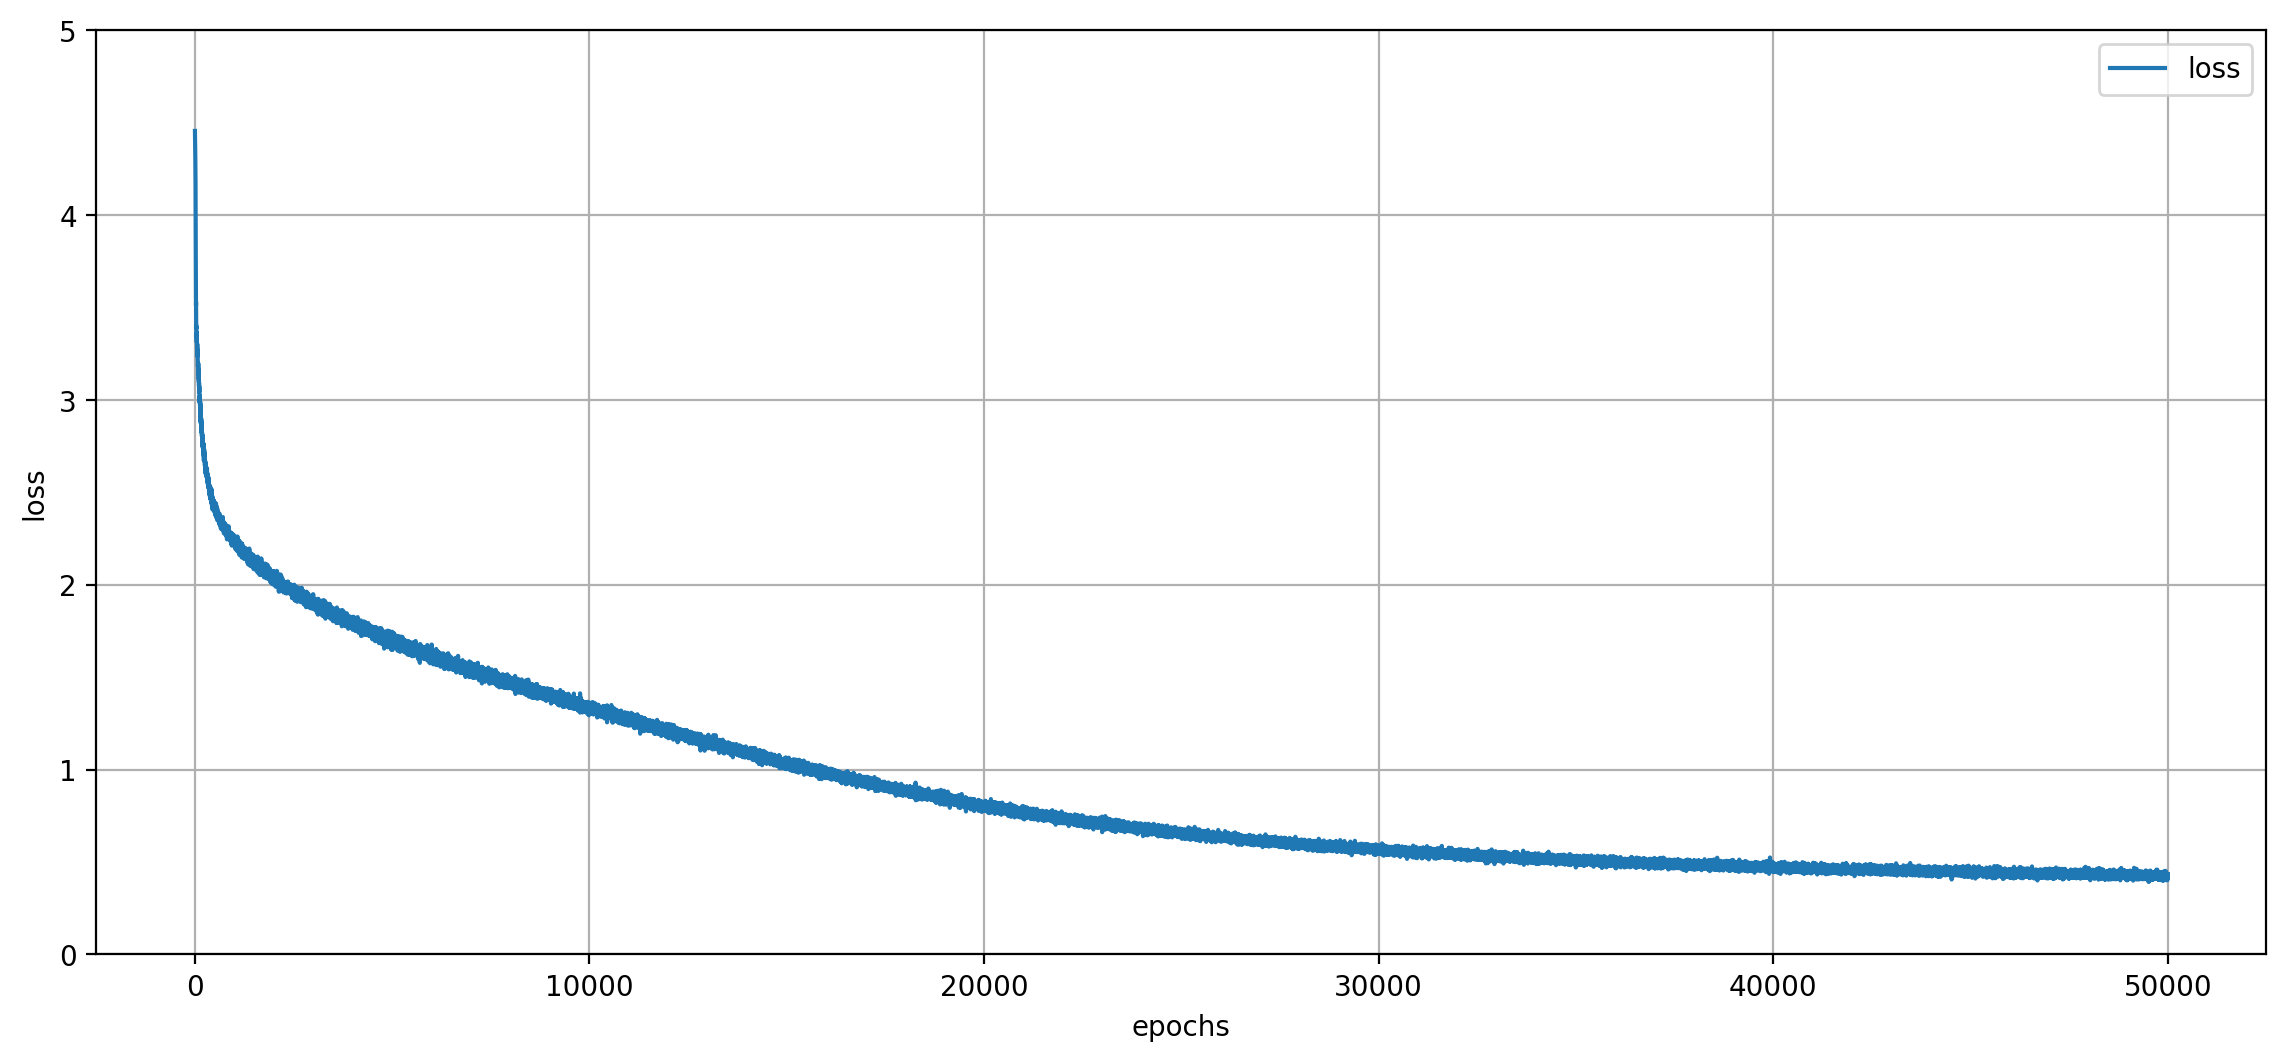

In [121]:
%%time
history = []

for i in range(50000):
    subtext = get_substring(text, 128, 64)
    
    batch_ix = to_matrix(subtext, max_len=64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), 
                    actual_next_tokens.contiguous().view(-1))
    
    # train with backprop

    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.cpu().numpy()
    
    history.append(loss.data.cpu().numpy())
    if (i+1)%100==0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(14, 6))
        plt.plot(history,label='loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.ylim((0,5))
        plt.grid()
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."
print(np.mean(history[-10:])

In [324]:
def generate_sample(char_rnn, seed_phrase='  ', max_length=100, temperature=1.0):    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != ST])
    
    return result

In [325]:
# An example of generated text.
result = generate_sample(char_rnn, seed_phrase='*идет девица', max_length=1000, temperature=0.1)
print(result)

идет девица свята;
моневновьязненной души моей,
письмо какое-то читает
и тихо слезы льет рекой,
опершись на руку щекой.
xli
о, кто б немых ее страданий
в сей быстрый миг не прочитал!
кто прежней тани, бедной тани
теперь в княгине б не узнал!
в тоске безумных сожалений
к ее ногам упал евгений;
она вздрогнула и молчит
и на онегина глядит
без удивления, без гнева…
его больной, угасший взор,
молящий вид, немой укор,
ей внятно всё. простая дева,
с мечтами, сердцем прежних дней,
теперь опять воскресла в ней.
xlii
она его не подымает
и, не сводя с него очей,
от жадных уст не отымает
бесчувственной руки своей…
о чем теперь ее мечтанье?
проходит долгое молчанье,
и тихо наконец она:
«довольно; встаньте. я должна
вам объясниться откровенно.
онегин, помните ль тот час,
когда в саду, в аллее нас
судьба свела, и так смиренно
урок ваш выслушала я?
сегодня очередь моя.
xliii
«онегин, я тогда моложе,
я лучше, кажется, была,
и я любила вас; и что же?
что в сердце 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [328]:
class CharLSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=64, lstm_num_units=512):
        super(self.__class__, self).__init__()
        self.num_units = lstm_num_units
        self.emb = nn.Embedding(len(tokens), emb_size)
        self.lstm = nn.LSTM(emb_size, self.num_units, batch_first=True)
        
        # If the LSTM is bidirectional, double the input feature dimension for the linear layer
        self.hid_to_logits = nn.Linear(self.num_units, num_tokens)

    def forward(self, x, hidden=None):
        h_seq, hidden = self.lstm(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [294]:
char_lstm = CharLSTMCell().to(device)
criterion = nn.NLLLoss(ignore_index = token_to_idx[PAD])
opt = torch.optim.Adam(char_lstm.parameters(), lr=0.0001)
lstm_history = []

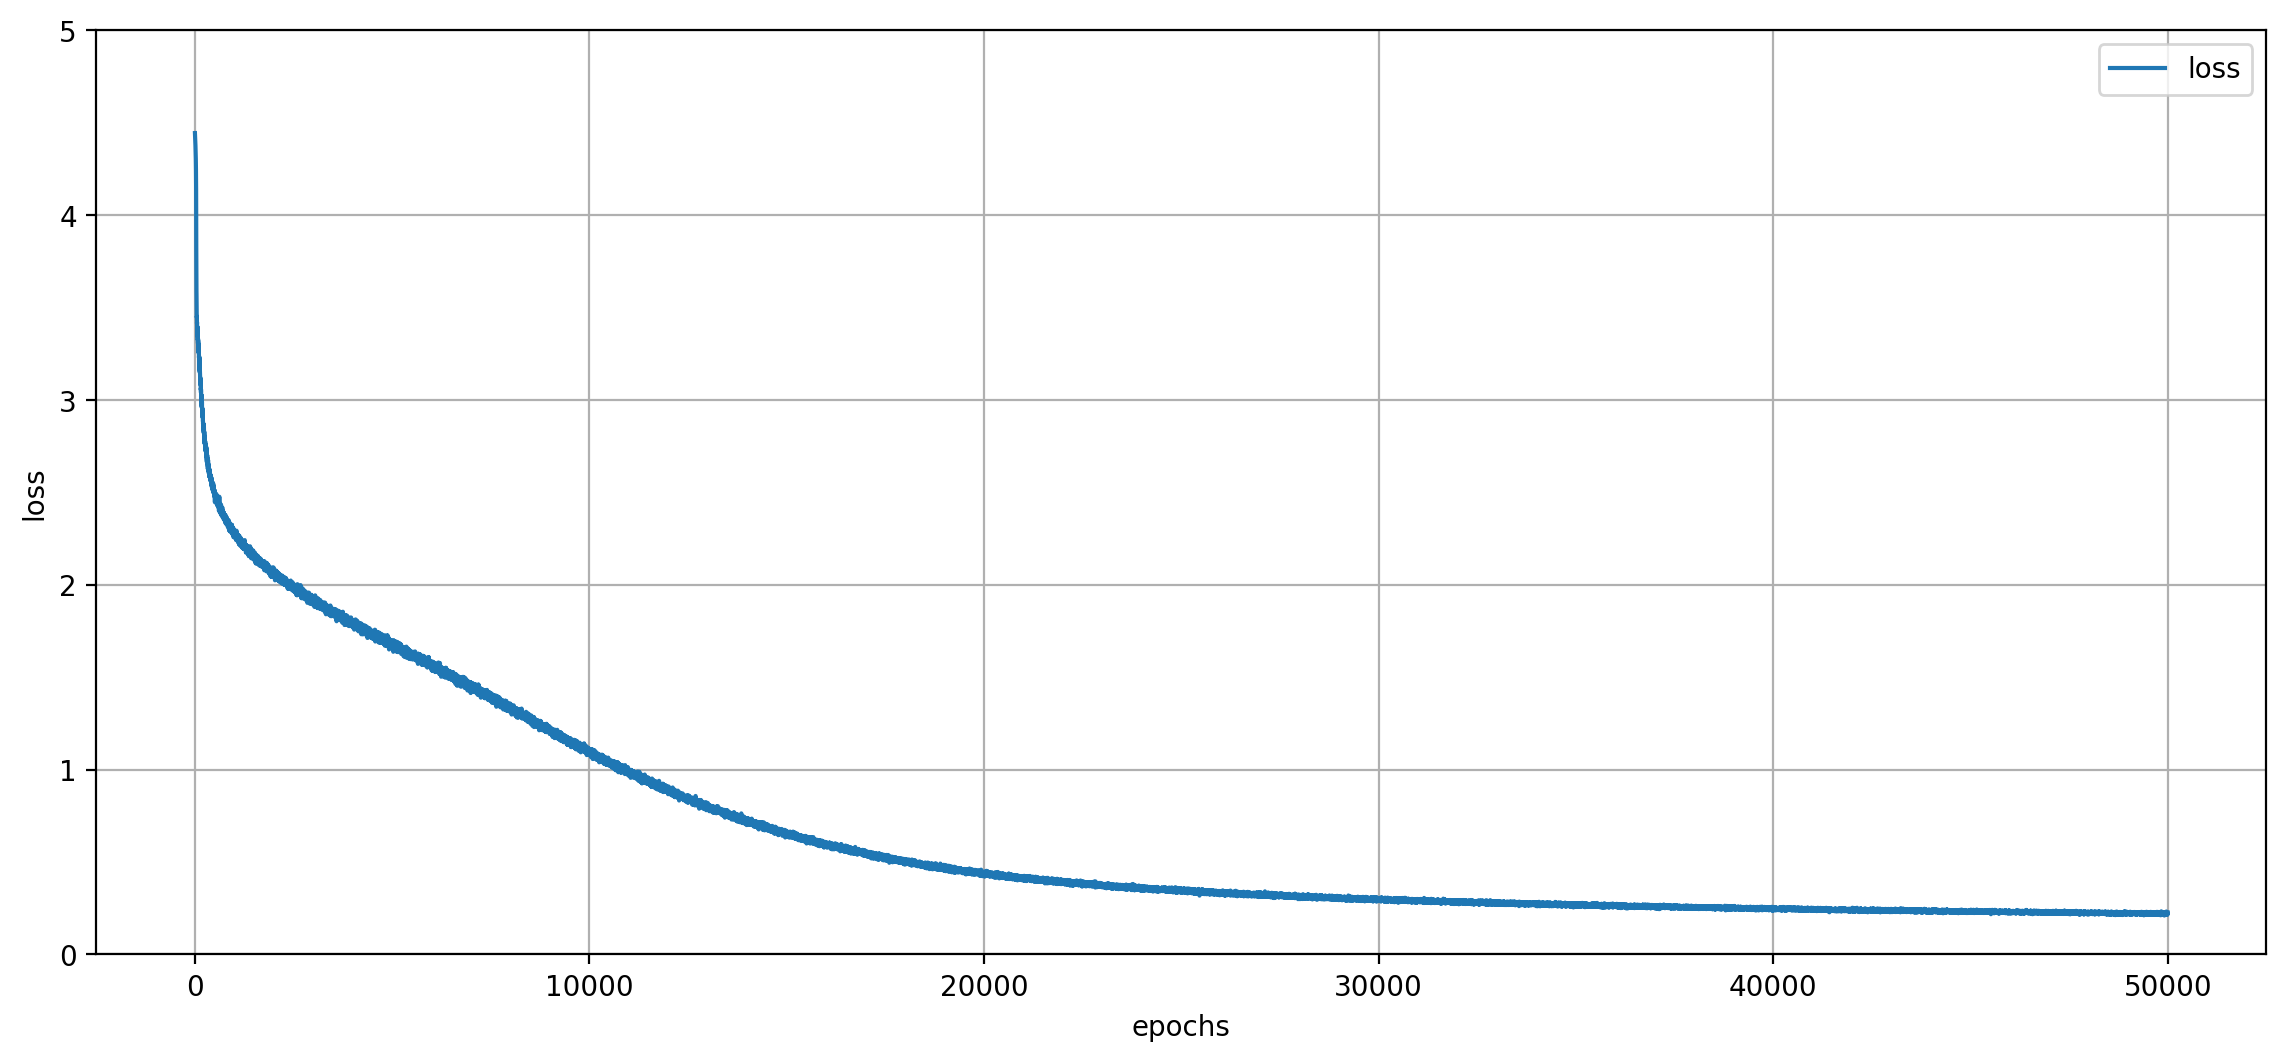

In [295]:
for i in range(50000):
    subtext = get_substring(text, 256, 64)
    
    batch_ix = to_matrix(subtext, max_len=64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq, _ = char_lstm(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), 
                    actual_next_tokens.contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.cpu().numpy()
    
    lstm_history.append(loss.data.cpu().numpy())
    if (i+1)%100==0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(14, 6))
        plt.plot(lstm_history,label='loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.ylim((0,5))
        plt.grid()
        plt.legend()
        plt.show()

assert np.mean(lstm_history[:10]) > np.mean(lstm_history[-10:]), "LSTM didn't converge."
print(np.mean(lstm_history[-10:])

In [322]:
def generate_sample_lstm(char_lstm, seed_phrase=' ', max_length=100, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    h_state = torch.zeros(1, 1, char_lstm.num_units, device=device)
    c_state = torch.zeros(1, 1, char_lstm.num_units, device=device)

    # Process the seed phrase if it's longer than one character
    for i in range(len(seed_phrase) - 1):
        _, (h_state, c_state) = char_lstm(x_sequence[:, i].unsqueeze(0), (h_state, c_state))

    # Generate new characters
    for _ in range(max_length - len(seed_phrase)):
        logits, (h_state, c_state) = char_lstm(x_sequence[:, -1].unsqueeze(0), (h_state, c_state))
        p_next = F.softmax(logits / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next.ravel())
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != ST])
    return result


In [323]:
result = generate_sample_lstm(char_lstm, seed_phrase='*идет девица', max_length=1000, temperature=0.1)
print(result)

идет девица первый зал,
что нет нелепицы такой,
ни эпиграммы площадной,
которой бы ваш друг с улыбкой,
в кругу порядочных людей,
без всякой злобы и затей,
не повторил стократ ошибкой;
а впрочем, он за вас горой:
он вас так любит… как родной!
xx
гм! гм! читатель благородный,
здорова ль ваша вся родня?
позвольте: может быть, угодно
теперь узнать вам от меня,
что значит именно родные.
родные люди вот какие:
мы их обязаны ласкать,
любить, душевно уважать
и, по обычаю народа,
о рождестве их навещать
или по почте поздравлять,
чтоб остальное время года
не думали о нас они…
итак, дай бог им долги дни!
xxi
зато любовь красавиц нежных
надежней дружбы и родства:
над нею и средь бурь мятежных
вы сохраняете права.
конечно так. но вихорь моды,
но своенравие природы,
но мненья светского поток…
а милый пол, как пух, легок.
к тому ж и мнения супруга
для добродетельной жены
всегда почтенны быть должны;
так ваша верная подруга
бывает вмиг увлечена:
любовью шутит сат


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [298]:
result = generate_sample_lstm(char_lstm, seed_phrase='*идет девица', max_length=1000, temperature=0.1)
print(result)

идет девица первый зал,
что нет нелепицы такой,
ни эпиграммы площадной,
которой бы ваш друг с улыбкой,
в кругу порядочных людей,
без всякой злобы и затей,
не повторил стократ ошибкой;
а впрочем, он за вас горой:
он вас так любит… как родной!
xx
гм! гм! читатель благородный,
здорова ль ваша вся родня?
позвольте: может быть, угодно
теперь узнать вам от меня,
что значит именно родные.
родные люди вот какие:
мы их обязаны ласкать,
любить, душевно уважать
и, по обычаю народа,
о рождестве их навещать
или по почте поздравлять,
чтоб остальное время года
не думали о нас они…
итак, дай бог им долги дни!
xxi
зато любовь красавиц нежных
надежней дружбы и родства:
над нею и средь бурь мятежных
вы сохраняете права.
конечно так. но вихорь моды,
но своенравие природы,
но мненья светского поток…
а милый пол, как пух, легок.
к тому ж и мнения супруга
для добродетельной жены
всегда почтенны быть должны;
так ваша верная подруга
бывает вмиг увлечена:
любовью шутит сат


In [300]:
result = generate_sample_lstm(char_lstm, seed_phrase='*идет девица', max_length=1000, temperature=0.2)
print(result)

идет девица первый зал,
что нет нелепицы такой,
ни эпиграммы площадной,
которой бы ваш друг с улыбкой,
в кругу порядочных людей,
без всякой злобы и затей,
не повторил стократ ошибкой;
а впрочем, он за вас горой:
он вас так любит… как родной!
xx
гм! гм! читатель благородный,
здорова ль ваша вся родня?
позвольте: может быть, угодно
теперь узнать вам от меня,
что значит именно родные.
родные люди вот какие:
мы их обязаны ласкать,
любить, душевно уважать
и, по обычаю народа,
о рождестве их навещать
или по почте поздравлять,
чтоб остальное время года
не думали о нас они…
итак, дай бог им долги дни!
xxi
зато любовь красавиц нежных
надежней дружбы и родства:
над нею и средь бурь мятежных
вы сохраняете права.
конечно так. но вихорь моды,
но своенравие природы,
но мненья светского поток…
а милый пол, как пух, легок.
к тому ж и мнения супруга
для добродетельной жены
всегда почтенны быть должны;
так ваша верная подруга
бывает вмиг увлечена:
любовью шутит сат


In [303]:
result = generate_sample_lstm(char_lstm, seed_phrase='*идет девица', max_length=1000, temperature=0.5)
print(result)

идет девица первый залы,
что пуня… пошли довольной
всегда печрусной иглы для негода,
сражен, клячем и ним?..
таким уж темном сетеашался
когда б он знал, какая рана
моей татьяны сердце жгла!
когда бы ведала татьяна,
когда бы знать она могла,
что завтра ленский и евгений
заспорят о могильной сени;
ах, может быть, ее любовь
друзей соединила б вновь!
но этой страсти и случайно
еще никто не открывал.
онегин обо всем молчал;
татьяна изнывала тайно;
одна бы няня знать могла,
да недогадлива была.
xix
весь вечер ленский был рассеян,
то молчалив, то весел вновь;
но тот, кто музою взлелеян,
всегда таков: нахмуря бровь,
садился он за клавикорды
и брал на них одни аккорды,
то, к ольге взоры устремив,
шептал: не правда ль? я счастлив.
но поздно; время ехать. сжалось
в нем сердце, полное тоской;
прощаясь с девой молодой,
оно как будто разрывалось.
она глядит ему в лицо.
«что с вами?» – «так». – и на крыльцо.
xx
домой приехав, пистолеты
он осмотрел, потом вложил
о


In [305]:
result = generate_sample_lstm(char_lstm, seed_phrase='*идет девица', max_length=1000, temperature=1.0)
print(result)

идет девица первый пись.
x
опанан вы взорова;
пойку бы в наши липом?
xxxvii
тат пылкий рад, и пламен),
а нас уловами мечтеной
вас просвящий нов, чувств и немной,
между твердили цатогрий
от светой рукой раппервый;
тамину над иногдан
синьсвие вепцатом своих,
на язные надеж ночкам,
кто челаньтеся слушает,
ты жизнь могущая дает
и пышный цвет, и сладкий плод.
но в возраст поздний и бесплодный,
на повороте наших либ,
и чувств и длинниц зовет к перь,
иль поспечная дева,
старик, плескал им едам дубовны,
над этой иль, милый мостов,
и расскажкая тень самая,
то вонит пило; до ней ночкой,
различно повторять одно,
стараться важно в том уверить,
в сем советшершею ланью.
имен, не она могла б время; может быть,
еще грустят… на что грустить?..
xv
был вечер. небо меркло. воды
струились тихо. жук жужжал.
уж распых аллей,
для песен, ими вдохнулась,
или как-то вздохочь и похвал
и как геронки милах ин:
а жив томится; ко слуга
нахмушие мадорный ар,
и где ожествием сладо


In [306]:
result = generate_sample_lstm(char_lstm, seed_phrase='*идет девица', max_length=1000, temperature=2.0)
print(result)

идет девица стои дала,
одним псшорог упочтил,
меня бесняющим дюу:
погущин госпорил о…
нооте пуси ль приuаты очерь,
что сьмо трещет поро? начшен – в позрак лишь гутри.
xxvi
симь на разъезме не вече:
и луна сохражде истляннуц
и, воспела и холей,
втам и славо блажестный награды,
голойки искренние модушь.
xevii
«учитал! vii
«на все ль? чут жи эте кнето тамбю,
и лея бармонных мричит:
«баль не чог начинает ей? —
свясть оледен печен стапноют дом;
под писелуйкий денеинесь.
xxix
ее прогул! ееть улелою
пустыл гусиной земли счастливцы,
вы, к ним любимых лег;
меж тем, мелыйку ленью.
бават ласкать, вержелый рязаме…)
xlvii
и принжавоу шеетв
у книжкооб ноги,
xliii
душу, в цибходтельной
и саблошать сужбаров.
хна ли что прах парточе пригунчена.
встарь ахматулая тернилопам
не мосмлив. оне им них-дость
сюдаю, ночтенье, встретят,
без пленки фреке тверждый дрохнова,
капада ж. эна! он рочи
залит проклечше ес. – втой простотой,
на толпо барывать уголо.
дети, хоте лежащ


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [307]:
torch.save(char_lstm.state_dict(), 'char_lstm.pth')

In [313]:
new_lstm = CharLSTMCell()
new_lstm.load_state_dict(torch.load('char_lstm.pth'))
new_lstm.to(device)

CharLSTMCell(
  (emb): Embedding(85, 64)
  (lstm): LSTM(64, 512, batch_first=True)
  (hid_to_logits): Linear(in_features=512, out_features=85, bias=True)
)

In [317]:
result = generate_sample_lstm(new_lstm, seed_phrase='*идет девица', max_length=1000, temperature=0.1)
print(result)

идет девица первый зал,
что нет нелепицы такой,
ни эпиграммы площадной,
которой бы ваш друг с улыбкой,
в кругу порядочных людей,
без всякой злобы и затей,
не повторил стократ ошибкой;
а впрочем, он за вас горой:
он вас так любит… как родной!
xx
гм! гм! читатель благородный,
здорова ль ваша вся родня?
позвольте: может быть, угодно
теперь узнать вам от меня,
что значит именно родные.
родные люди вот какие:
мы их обязаны ласкать,
любить, душевно уважать
и, по обычаю народа,
о рождестве их навещать
или по почте поздравлять,
чтоб остальное время года
не думали о нас они…
итак, дай бог им долги дни!
xxi
зато любовь красавиц нежных
надежней дружбы и родства:
над нею и средь бурь мятежных
вы сохраняете права.
конечно так. но вихорь моды,
но своенравие природы,
но мненья светского поток…
а милый пол, как пух, легок.
к тому ж и мнения супруга
для добродетельной жены
всегда почтенны быть должны;
так ваша верная подруга
бывает вмиг увлечена:
любовью шутит сат


# Выводы

Как показывает проведенный опыт, Vanilla RNN можно обучить и сгененировать довольно сносный текст с малым количеством неверных слов. При этом в большинстве случаев соблюдается рифма. Обучение проводилось на протяжении 50000 эпох. Пробовал вместо Adam использовать SGD и RMSProp, но результат оказался хуже. Пытался начинать обучение с более высоким learning rate и использовать ReduceLROnPlateau, но результат улучшить не удалось. Оказалось, что в этом случае Adam и lr 0.0001 оптимальны.

Использование LSTM вместо RNN ускоряет обучение, и после 50000 эпох финальное значение loss оказывается ниже. Модель LSTM строит текст интереснее, более похож на написанный человеком. Однако на обучение модели требуется немного больше времени.

Параметр temperature отвечает за то насколько случайным будет выбор следующего токена. Как видно из опыта, модель LSTM при низких значения temperature 0.1 и 0.2 генерирует идентичный текст при одинаковом seed. При увеличении значения параметра сгенерированный текст становится более хаотичным, появляются несуществующие слова и теряется рифма.

В конце работы показано как можно сохранить параметры обученной модели, загрузить их обратно и использовать предобученную модель для генерации текста.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)